In [70]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/AI_HW/HW1

In [71]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# load MNIST dataset 
image_size = 28           # width and length
no_of_different_labels = 10     #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",") 

# data preprocessing

# map pixels information from range(0, 255) to range(0.01, 1)
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float64)
test_labels_one_hot = (lr==test_labels).astype(np.float64)

In [72]:
x_train,x_val,y_train,y_val=train_test_split(train_imgs,train_labels_one_hot,test_size=0.2,random_state=9)

In [73]:
class NeuralNetwork:
    def __init__(self, X, y,val_x,val_y, batch = 120, lr = 1e-3,  epochs = 50):
        self.input = X 
        self.target = y
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
        self.x = self.input[:self.batch] # batch input 
        self.y = self.target[:self.batch] # batch target value
        self.loss = []
        self.acc = []
        self.val_loss=[]
        self.val_acc=[]
        self.val_x=val_x
        self.val_y=val_y
        
        
        self.init_weights()
      
    def init_weights(self):
        self.W1 = np.random.randn(self.input.shape[1],256)
        self.W2 = np.random.randn(self.W1.shape[1],128)
        self.W3 = np.random.randn(self.W2.shape[1],self.y.shape[1])

        self.b1 = np.random.randn(self.W1.shape[1],)
        self.b2 = np.random.randn(self.W2.shape[1],)
        self.b3 = np.random.randn(self.W3.shape[1],)

    def ReLU(self, x):
        return np.maximum(0,x)

    def dReLU(self,x):
        return 1 * (x > 0) 
    
    def softmax(self, z):
        z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
        return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
    def shuffle(self):
        idx = [i for i in range(self.input.shape[0])]
        np.random.shuffle(idx)
        self.input = self.input[idx]
        self.target = self.target[idx]
        
    def feedforward(self):

        ## innper product
        self.z1 = self.x.dot(self.W1) + self.b1
        self.a1 = self.ReLU(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.ReLU(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        self.error = self.a3 - self.y

        
    def backprop(self):
        dcost = (1/self.batch)*self.error
        
        DW3 = np.dot(dcost.T,self.a2).T
        DW2 = np.dot((np.dot((dcost),self.W3.T) * self.dReLU(self.z2)).T,self.a1).T
        DW1 = np.dot((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)).T,self.x).T

        db3 = np.sum(dcost,axis = 0)
        db2 = np.sum(np.dot((dcost),self.W3.T) * self.dReLU(self.z2),axis = 0)
        db1 = np.sum((np.dot(np.dot((dcost),self.W3.T)*self.dReLU(self.z2),self.W2.T)*self.dReLU(self.z1)),axis = 0)
        
        self.W3 = self.W3 - self.lr * DW3
        self.W2 = self.W2 - self.lr * DW2
        self.W1 = self.W1 - self.lr * DW1
        
        self.b3 = self.b3 - self.lr * db3
        self.b2 = self.b2 - self.lr * db2
        self.b1 = self.b1 - self.lr * db1
    def train(self):
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            self.shuffle()
            for batch in range(self.input.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch+1)*self.batch
                self.x = self.input[start:end]
                self.y = self.target[start:end]
                self.feedforward()
                self.backprop()
                l+=np.mean(self.error**2)
                criterion=nn.CrossEntropyLoss()
                #l+=criterion(self.a3,self.y)
                acc+= np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.batch
            
            # calculate validation loss accuracy
            self.x=self.val_x
            self.y=self.val_y
            val_size=self.y.shape[0]
            self.feedforward()

            self.val_loss.append(np.mean(self.error**2))
            val_acc=(np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / val_size)*100
            self.val_acc.append(val_acc)
            # training loss accuarcy
            self.loss.append(l/(self.input.shape[0]//self.batch))
            self.acc.append(acc*100/(self.input.shape[0]//self.batch))
            print("epochs:",epoch+1)
            print("training loss:",self.loss[-1])
            print("training accuracy:",self.acc[-1])
            print("validation loss:",self.val_loss[-1])
            print("validation accuracy",self.val_acc[-1])
            print("----------------------------")
            
    def loss_plot(self):
        plt.figure(dpi = 125)
        line1,=plt.plot(self.loss,"b-",label="train")
        line2,=plt.plot(self.val_loss,"y-",label="val")
        plt.legend(handles=[line1,line2])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        line1,=plt.plot(self.acc,"b-",label="train")
        line2,=plt.plot(self.val_acc,"y-",label="val")
        plt.legend(handles=[line1,line2])
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        
    def test(self,xtest,ytest):
        self.x = xtest
        self.y = ytest
        self.feedforward()
        acc = np.count_nonzero(np.argmax(self.a3,axis=1) == np.argmax(self.y,axis=1)) / self.x.shape[0]
        print("Accuracy:", 100 * acc, "%")
    
        
        


In [74]:
NN = NeuralNetwork(x_train, y_train,x_val,y_val) 
NN.train()
#NN.plot()
#NN.test(X_test,y_test)

epochs: 1
training loss: 0.08107824467338773
training accuracy: 59.06666666666663
validation loss: 0.05244691875127707
validation accuracy 73.675
----------------------------
epochs: 2
training loss: 0.04532373145557021
training accuracy: 76.97708333333334
validation loss: 0.041584752973682464
validation accuracy 79.10833333333333
----------------------------
epochs: 3
training loss: 0.03810782245513201
training accuracy: 80.56874999999995
validation loss: 0.03697632321570762
validation accuracy 81.38333333333333
----------------------------
epochs: 4
training loss: 0.03429173341964893
training accuracy: 82.48125
validation loss: 0.03450106032268146
validation accuracy 82.625
----------------------------
epochs: 5
training loss: 0.03205314800680019
training accuracy: 83.58749999999995
validation loss: 0.032830327521024626
validation accuracy 83.43333333333334
----------------------------
epochs: 6
training loss: 0.03011908821064303
training accuracy: 84.5479166666666
validation loss: 0

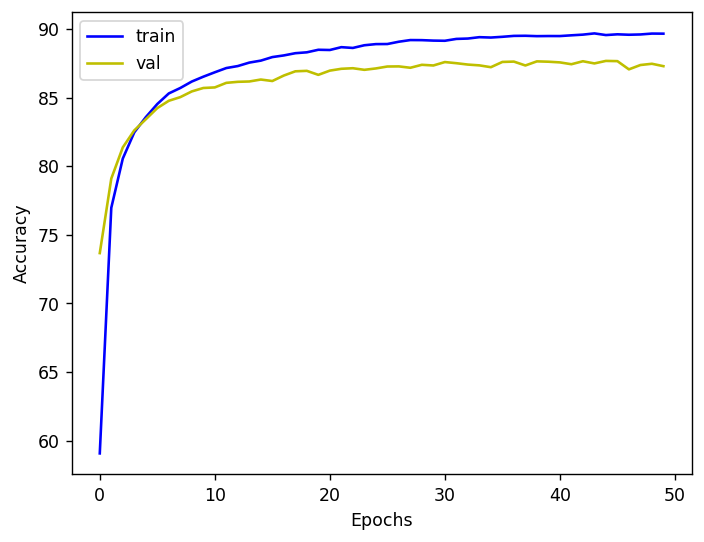

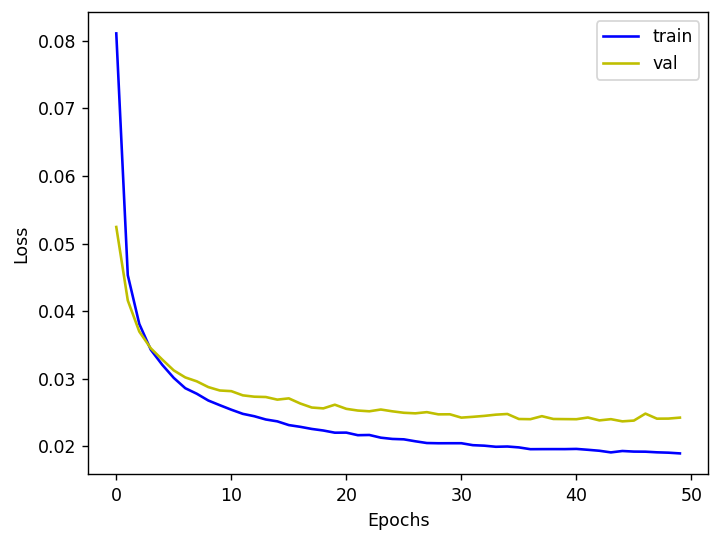

In [75]:
NN.acc_plot()
NN.loss_plot()

In [77]:
print(NN.val_acc[-1])

87.30833333333334
